# Grad-CAM 
This notebook is for training and understanding purposes only. All algorithms and credits go to pyimagesearch.com, specifically https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/ and Adrian Rosebrock (A wonderful source and inspiration for Computer Vision and Deep Learning)

<br>
As this notebook is for training and understanding purposes, rather than downloading the source code right away. The code will be typed in order to build "muscle-memory". Author-readable comments will appear from time to time.

Grad-CAM stands for Gradient-weighted Class Activation Mapping.
<br>
1. works with any CNN architecture
2. works at final layer of activation (specifically looking at gradient for (n-1)th and (n)th layer)
3. used to visually debug where a network is looking in an image (outputs a heatmap visualization)

In [1]:
## Library import
## We will be using three libraries
## 1) Tensorflow 2.0
## 2) imutils (developed by Adrian with many useful shortcuts)
## 3) opencv (an opensourced computer vision library developed with C++ and comes with a python wrapper)
## 4) numpy (an opensourced numerical library for python)
from tensorflow.keras.models import Model
from tensorflow.python import keras
import tensorflow as tf
import numpy as np
import cv2

In [6]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Similar to C++/C# where there is a constructor for a class object
        # python's class constructor is known as __init__ and has to carry a self to identify itself
        # similar to "this" in C#
        self.model = model # used to store the CNN model VGG16, VGG19, resnet50, etc
        self.classIdx = classIdx # class id for visualizing heat map (i.e. class 1 show heat map 1, class 2 show heat map 2) 
        self.layerName = layerName # the name of the (n-1)th layer. (i.e. right before classification layer) is this scope for tf layer?
        
        # what if the model layer has no name?
        if self.layerName is None:
            self.layerName = self.find_target_layer()
        
    # attempt to find final layer
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
        # reversed is python function to return an iterator (not list) that loops through the model layer in reversed order
            if len(layer.output_shape) == 4:
            # we check for shapes to be 4 because (number of kernels x kernel-x, kernel-y, kernel-z)
                print(layer.name)
                return layer.name
            
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
            
    def compute_heatmap(self, image, eps=1e-8):
        # construct a gradient model by using Keras models
        # input is an image, which is also the model's input layer
        # we also take the (n-1)th layer's output to calculate the gradient
        gradModel = tf.keras.Model(inputs=[self.model.inputs], 
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output],
                         )
            
        with tf.GradientTape() as tape:
            # tf.gradienttape is a context manager
            # that record operations for automatic differentiation.
            # every operations in the "tape" session can be accessed
            # we want to know the largest gradient flow between input and output
            # this "tape" records the automatic differentiation between inputs and outputs
            #
            # remember gradient descent is an optimization algorithm (optimizing a cost/loss/error function - could be mean-squared, rms, etc) 
            # that moves toward minimum loss region and in order to move toward minimum loss region
            # we use the direction of the gradient (negative/positive). We want negative gradient
            # Then in order to update the weights proportionately, we need to backpropagate to know how much to update
            # automatic differentiation (more specifically reversed mode autodiff) is a technique to breakdown the backpropagation with primitive steps
            #
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # extract the gradient flow
        # returns a nested structure of Tensors
        grads = tape.gradient(loss, convOutputs)
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")

        # since casting convoutputs and grads gives us binary mask
        # multiplication of these two matrices produce a  3d binary mask
        # see paper for explanation
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # now that we have the "cam" object which is really a 2d binary mask of size convOutputs and weights
        # we need to resize our "cam" object to match the image

        (w,h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w,h))

        # normalize to (0,1) with min-max scaling
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer/denom
        # scale to 255 and need to return "uint8" type to be able to display with opencv
        heatmap = (heatmap *255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # our heatmap is a greyscale image from 0-255, to make it colorful, we apply a colormap scheme
        heatmap = cv2.applyColorMap(heatmap, colormap)
        # alpha is the transparency index
        output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)

        return (heatmap, output)
            

In [ ]:
## in Adrian's blog, there is also a driver script to apply the GradCAM technique.
## For future usage, it is also included in this notebook
## before the use of this script, save the above code into GradCAM.py

import GradCAM
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import argparse
import imutils
import cv2

ap = argparse.ArgumentParser()
ap.add_argument("-i","--image", required=True, help="path to input image")
ap.add_argument("-m","--model", type=str, default="vgg", choices=("vgg","resnet"), help="model to be used")
args = vars(ap.parse_args())

Model = VGG16
if args["model"] == "resnet":
    Model = ResNet50
    
print("[INFO] loading model...")
model = Model(weights="imagenet")

orig = cv2.imread(args["image"])
resized = cv2.resize(orig, (224,224))

image = load_img(args["image"], target_size=(224,224))
image = img_to_array(image)
image = np.expand_dims(image,axis=0)
image = imagenet_utils.preprocess_input(image)

preds = model.predict(image)
i = np.argmax(preds[0])

decoded = imagenet_utils.decode_predictions(preds)
(imagenetId, label, prob0 = decoded[0][0])
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

cam = GradCam(model, i)
heatmap = cam.compute_heatmap(image)

heatmap = cv2.resize(heatmap, orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2.imshow("Output", output)
cv2.waitKey(0)

[INFO] loading model...
[INFO] golden_retriever: 97.44%
conv5_block3_out


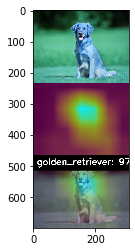

In [8]:
# notebook use
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Model = ResNet50
print("[INFO] loading model...")
model = Model(weights="imagenet")

orig = cv2.imread("dog.jpeg")
resized = cv2.resize(orig, (224,224))

image = load_img("dog.jpeg", target_size=(224,224))
image = img_to_array(image)
image = np.expand_dims(image,axis=0)
image = imagenet_utils.preprocess_input(image)

preds = model.predict(image)
i = np.argmax(preds[0])

decoded = imagenet_utils.decode_predictions(preds)
(imagenetId, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
plt.imshow(output)
plt.show()